<a href="https://colab.research.google.com/github/FerranHeredia/TFG_FerranHeredia_TrayectoriasFutbol/blob/main/ProyectoTrayectoriasFutbol_TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalamos librerias

In [1]:
!pip install mplsoccer matplotlib
!pip install ace_tools
!pip install fastdtw
!pip install MDAnalysis numpy scipy matplotlib seaborn six future
!pip install -e git+https://github.com/LoLab-VU/PyBILT@v0.2.0#egg=pybilt
!pip install pybilt sdt-python
!pip install ruptures
!pip install hurst
!pip install pybilt fastdtw
!pip install scikit-learn numpy pandas matplotlib
!pip install andi_datasets


Obtaining pybilt from git+https://github.com/LoLab-VU/PyBILT@v0.2.0#egg=pybilt
  Updating ./src/pybilt clone (to revision v0.2.0)
  Running command git fetch -q --tags
  Running command git reset --hard -q a077421b4397ae15e5824782f740324f5bde29db
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pybilt
    Found existing installation: pybilt 0.2.0
    Uninstalling pybilt-0.2.0:
      Successfully uninstalled pybilt-0.2.0
  Running setup.py develop for pybilt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take in

# Cargamos y graficamos datos


In [1]:
from google.colab import files
uploaded = files.upload()

Saving 15946.json to 15946.json


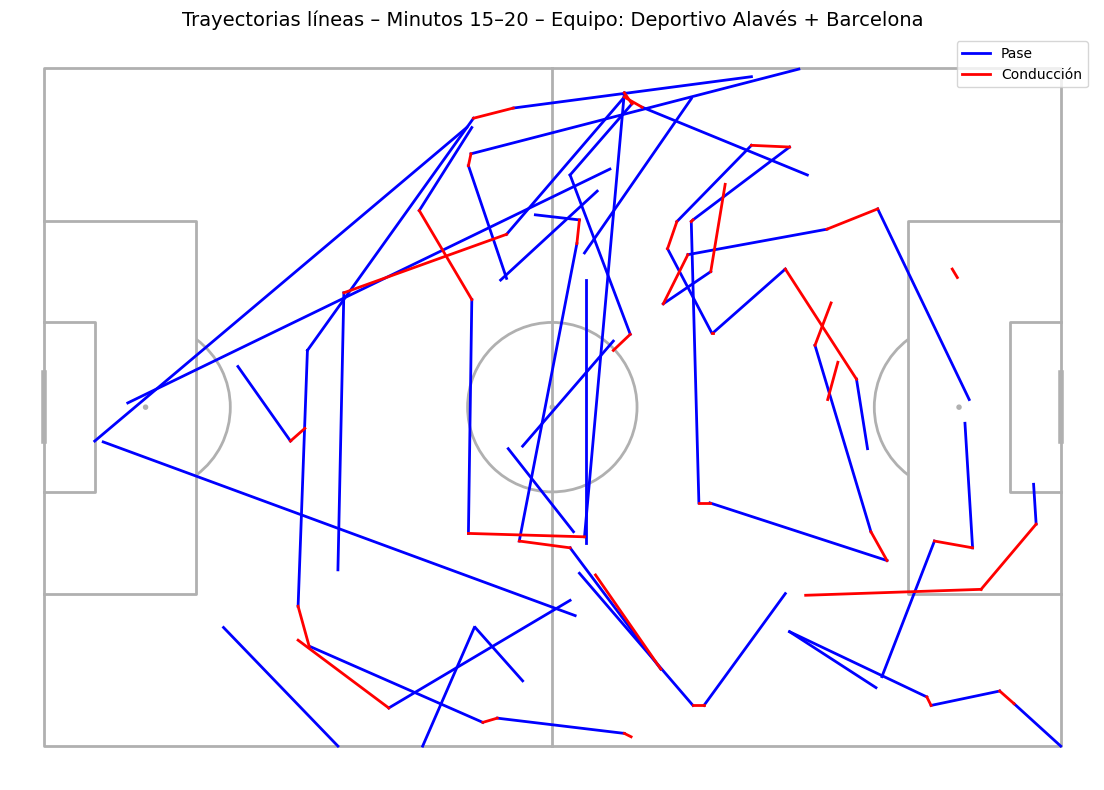

[(91.0, 32.7, 97.6, 54.7), (99.5, 58.1, 78.6, 51.3), (77.3, 51.3, 76.4, 18.1), (76.6, 17.9, 88.0, 9.3), (83.5, 9.1, 74.7, 18.1), (73.6, 21.3, 78.8, 31.2), (79.0, 31.2, 87.5, 23.7), (95.9, 36.7, 97.2, 44.9), (22.9, 35.2, 29.1, 44.0), (9.9, 39.5, 66.8, 11.9), (65.3, 14.5, 53.9, 25.0), (54.6, 24.8, 50.1, 11.5), (50.4, 10.1, 89.1, 0.1), (44.7, 80.0, 50.8, 66.0), (50.9, 66.0, 56.5, 72.3), (78.7, 24.0, 73.1, 27.8), (76.0, 22.0, 92.4, 19.0), (98.4, 16.6, 109.2, 39.1), (6.0, 44.0, 49.9, 7.0), (50.5, 7.0, 44.3, 16.8), (50.5, 27.3, 50.1, 54.9), (63.8, 55.3, 68.5, 2.9), (69.4, 4.2, 62.1, 12.6), (62.1, 12.6, 69.2, 31.4), (67.2, 32.2, 56.5, 44.6), (54.8, 44.9, 62.5, 54.7), (63.2, 59.6, 76.6, 75.2), (77.9, 75.2, 87.5, 62.0), (117.1, 53.8, 116.8, 49.1), (120.0, 80.0, 114.5, 75.0), (112.8, 73.5, 104.7, 75.2), (104.2, 74.2, 88.0, 66.5), (88.0, 66.5, 98.2, 73.1), (98.9, 71.8, 105.1, 55.8), (109.6, 56.6, 108.7, 41.9), (7.0, 44.1, 62.7, 64.6), (68.5, 78.5, 53.5, 76.7), (51.8, 77.2, 31.3, 68.2), (30.0, 63.

In [2]:
import json
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.lines import Line2D

# Parámetros de entrada
ARROWS = False     # True ➝ flechas, False ➝ líneas
TEAM_OPTION = 3   # 1: local, 2: visitante, 3: ambos
MIN_START = 15     # minuto de inicio
MIN_END = 20      # minuto de fin

# Cargar datos
with open('15946.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Detectar nombres de equipos
equipos = list({ev.get('team', {}).get('name', '') for ev in data if ev.get('team')})
home_team, away_team = (equipos + [None, None])[:2]

def filtrar_por_equipo(ev):
    name = ev.get('team', {}).get('name', '')
    return (TEAM_OPTION == 3 or
            (TEAM_OPTION == 1 and name == home_team) or
            (TEAM_OPTION == 2 and name == away_team))

# Recopilar pasos y conducciones
passes, carries = [], []
for ev in data:
    m = ev.get('minute', 0)
    if not (MIN_START <= m < MIN_END): continue
    if not filtrar_por_equipo(ev): continue
    loc = ev.get('location')
    if not loc: continue

    if ev['type']['name'] == 'Pass' and ev['pass'].get('end_location'):
        x0, y0 = loc
        x1, y1 = ev['pass']['end_location']
        passes.append((x0, y0, x1, y1))
    elif ev['type']['name'] == 'Carry' and ev['carry'].get('end_location'):
        x0, y0 = loc
        x1, y1 = ev['carry']['end_location']
        carries.append((x0, y0, x1, y1))

# Inicializar gráfico
pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
fig, ax = pitch.draw(figsize=(12, 8))

# Funciones de dibujo
def dibujar_flechas(lst, color):
    for x0, y0, x1, y1 in lst:
        dx, dy = x1 - x0, y1 - y0
        ax.arrow(x0, y0, dx, dy,
                 length_includes_head=True, head_width=1.5,
                 head_length=2.5, width=0.3,
                 fc=color, ec=color, alpha=0.8)

def dibujar_lineas(lst, color):
    for x0, y0, x1, y1 in lst:
        ax.plot([x0, x1], [y0, y1], color=color, linewidth=2)

# Representar según parámetro
if ARROWS:
    dibujar_flechas(passes, 'blue')
    dibujar_flechas(carries, 'red')
else:
    dibujar_lineas(passes, 'blue')
    dibujar_lineas(carries, 'red')

# Leyenda
legend = [
    Line2D([0], [0], color='blue', lw=2, label='Pase'),
    Line2D([0], [0], color='red', lw=2, label='Conducción')
]
ax.legend(handles=legend, loc='upper right')

# Etiqueta del equipo
if TEAM_OPTION == 1:
    team_label = home_team
elif TEAM_OPTION == 2:
    team_label = away_team
else:
    team_label = f"{home_team} + {away_team}"

ax.set_title(f"Trayectorias {('flechas' if ARROWS else 'líneas')} – "
             f"Minutos {MIN_START}–{MIN_END} – Equipo: {team_label}",
             fontsize=14)

plt.show()
print(passes)

# GENERACIÓN DE TRAYECTORIAS SINTÉTICAS


## Extraemos parámetros estadísticos.




In [1]:
from google.colab import files
uploaded = files.upload()

Saving 19764.json to 19764.json
Saving 16240.json to 16240.json
Saving 3775635.json to 3775635.json
Saving 15946.json to 15946.json


In [10]:
# ============================================================
# Multi-partidos (Colab) -> Resumen global + Hurst 2D (DFA)
# ============================================================

import json
import numpy as np
import pandas as pd
from google.colab import files

# Mostrar floats con 3 decimales
pd.options.display.float_format = "{:.3f}".format

# -----------------------------
# Utilidades de Hurst por DFA
# -----------------------------
def _dfa_fluctuation(y: np.ndarray, window_sizes: np.ndarray):
    n_valid, F = [], []
    for n in np.unique(window_sizes.astype(int)):
        if n < 4 or n > len(y):
            continue
        m = len(y) // n
        if m < 2:
            continue
        y_use = y[:m * n].reshape(m, n)
        t = np.arange(n)
        A = np.vstack([t, np.ones_like(t)]).T
        pinvA = np.linalg.pinv(A)
        coef = (pinvA @ y_use.T)
        trend = (A @ coef).T
        resid = y_use - trend
        rms = np.sqrt(np.mean(resid**2, axis=1))
        F.append(np.sqrt(np.mean(rms**2)))
        n_valid.append(n)
    return np.array(n_valid, int), np.array(F, float)

def hurst_dfa(series: np.ndarray, n_min=4, n_max=None, num_scales=12) -> float:
    x = np.asarray(series, float)
    x = x[np.isfinite(x)]
    N = x.size
    if N < 16:
        return np.nan
    y = np.cumsum(x - x.mean())
    if n_max is None:
        n_max = max(8, N // 4)
    n_vals = np.logspace(np.log10(n_min), np.log10(n_max), num=num_scales)
    n_valid, F = _dfa_fluctuation(y, n_vals)
    if F.size < 5 or np.any(F <= 0):
        return np.nan
    slope, _ = np.polyfit(np.log(n_valid), np.log(F), 1)
    return float(slope)

def hurst_xy_avg(x: np.ndarray, y: np.ndarray) -> float:
    Hx = hurst_dfa(x)
    Hy = hurst_dfa(y)
    return float(np.nanmean([Hx, Hy]))


# ------------------------------------------
# Acumuladores globales
# ------------------------------------------
pass_lengths, carry_lengths = [], []
steps_per_possession_all = []
hurst_vals = []
num_files = 0
num_possessions_total = 0

# ------------------------------------------
# Parse de cada archivo y acumulación global
# ------------------------------------------

for fname, file_bytes in uploaded.items():
    num_files += 1
    try:
        obj = json.loads(file_bytes.decode("utf-8"))
    except Exception:
        obj = json.loads(file_bytes)

    # hallar la lista de eventos
    data = obj
    if isinstance(obj, dict):
        for k, v in obj.items():
            if isinstance(v, list) and len(v) > 0 and isinstance(v[0], dict) and "type" in v[0]:
                data = v
                break
    if not isinstance(data, list):
        print(f"⚠️ {fname}: formato no reconocido, lo omito.")
        continue

    # ordenar por tiempo
    data_sorted = sorted(data, key=lambda ev: (ev.get("minute", 0), ev.get("second", 0)))

    possessions = {}
    coords = []

    for ev in data_sorted:
        poss_id = ev.get("possession")
        if poss_id is not None:
            possessions.setdefault(poss_id, []).append(ev)

        loc = ev.get("location")
        if isinstance(loc, list) and len(loc) >= 2:
            coords.append((float(loc[0]), float(loc[1])))

        tname = ev.get("type", {}).get("name")

        # Pass
        if tname == "Pass":
            pdict = ev.get("pass", {})
            if "length" in pdict:
                pass_lengths.append(float(pdict["length"]))

        # Carry
        if tname == "Carry":
            loc_end = ev.get("carry", {}).get("end_location")
            if loc and loc_end:
                xs = np.array(loc[:2], float)
                ys = np.array(loc_end[:2], float)
                carry_lengths.append(float(np.linalg.norm(ys - xs)))

    # pasos por posesión
    for evs in possessions.values():
        pasos = sum(1 for e in evs if e.get("type", {}).get("name") in ("Pass", "Carry"))
        steps_per_possession_all.append(pasos)
    num_possessions_total += len(possessions)

    # Hurst
    if len(coords) >= 16:
        arr = np.array(coords, float)
        H = hurst_xy_avg(arr[:, 0], arr[:, 1])
        if np.isfinite(H):
            hurst_vals.append(H)

# ------------------------------------------
# Helper resumen
# ------------------------------------------
def summarize(arr_like):
    a = np.array(arr_like, float)
    if a.size == 0:
        return dict(mean=np.nan, median=np.nan, std=np.nan, min=np.nan, max=np.nan, count=0)
    return {
        "mean":   float(np.nanmean(a)),
        "median": float(np.nanmedian(a)),
        "std":    float(np.nanstd(a, ddof=1)) if a.size > 1 else 0.0,
        "min":    float(np.nanmin(a)),
        "max":    float(np.nanmax(a)),
        "count":  int(a.size)
    }

# ------------------------------------------
# Resumen global
# ------------------------------------------
passes_stats  = summarize(pass_lengths)
carries_stats = summarize(carry_lengths)
steps_stats   = summarize(steps_per_possession_all)

H_vals = np.array(hurst_vals, float)
H_mean = float(np.nanmean(H_vals)) if H_vals.size else np.nan
H_std  = float(np.nanstd(H_vals, ddof=1)) if H_vals.size > 1 else (0.0 if H_vals.size == 1 else np.nan)

summary = pd.DataFrame({
    "Archivos": {
        "Partidos cargados": num_files,
        "Partidos con Hurst válido": int(H_vals.size)
    },
    "Frecuencias": {
        "p_pass": len(pass_lengths) / (len(pass_lengths)+len(carry_lengths)) if (len(pass_lengths)+len(carry_lengths)) else np.nan,
        "p_carry": len(carry_lengths) / (len(pass_lengths)+len(carry_lengths)) if (len(pass_lengths)+len(carry_lengths)) else np.nan
    },
    "Pases (longitud)": {
        "count": passes_stats["count"],
        "mean": passes_stats["mean"],
        "median": passes_stats["median"],
        "std": passes_stats["std"],
        "min": passes_stats["min"],
        "max": passes_stats["max"]
    },
    "Carries (longitud)": {
        "count": carries_stats["count"],
        "mean": carries_stats["mean"],
        "median": carries_stats["median"],
        "std": carries_stats["std"],
        "min": carries_stats["min"],
        "max": carries_stats["max"]
    },
    "Posesiones": {
        "num_total": num_possessions_total,
        "num_trayectorias": steps_stats["count"],
        "mean_steps": steps_stats["mean"],
        "median_steps": steps_stats["median"],
        "std_steps": steps_stats["std"],
        "min_steps": steps_stats["min"],
        "max_steps": steps_stats["max"]
    },
    "Hurst 2D": {
        "mean": H_mean,
        "std": H_std
    }
})

print("\n📊 === RESUMEN GLOBAL (agregado sobre todos los partidos) ===")
print(summary.to_string(float_format="%.3f"))



📊 === RESUMEN GLOBAL (agregado sobre todos los partidos) ===
                           Archivos  Frecuencias  Pases (longitud)  Carries (longitud)  Posesiones  Hurst 2D
Partidos cargados             4.000          NaN               NaN                 NaN         NaN       NaN
Partidos con Hurst válido     4.000          NaN               NaN                 NaN         NaN       NaN
p_pass                          NaN        0.555               NaN                 NaN         NaN       NaN
p_carry                         NaN        0.445               NaN                 NaN         NaN       NaN
count                           NaN          NaN          4102.000            3284.000         NaN       NaN
mean                            NaN          NaN            20.904               5.115         NaN     0.686
median                          NaN          NaN            16.643               3.046         NaN       NaN
std                             NaN          NaN            14.355

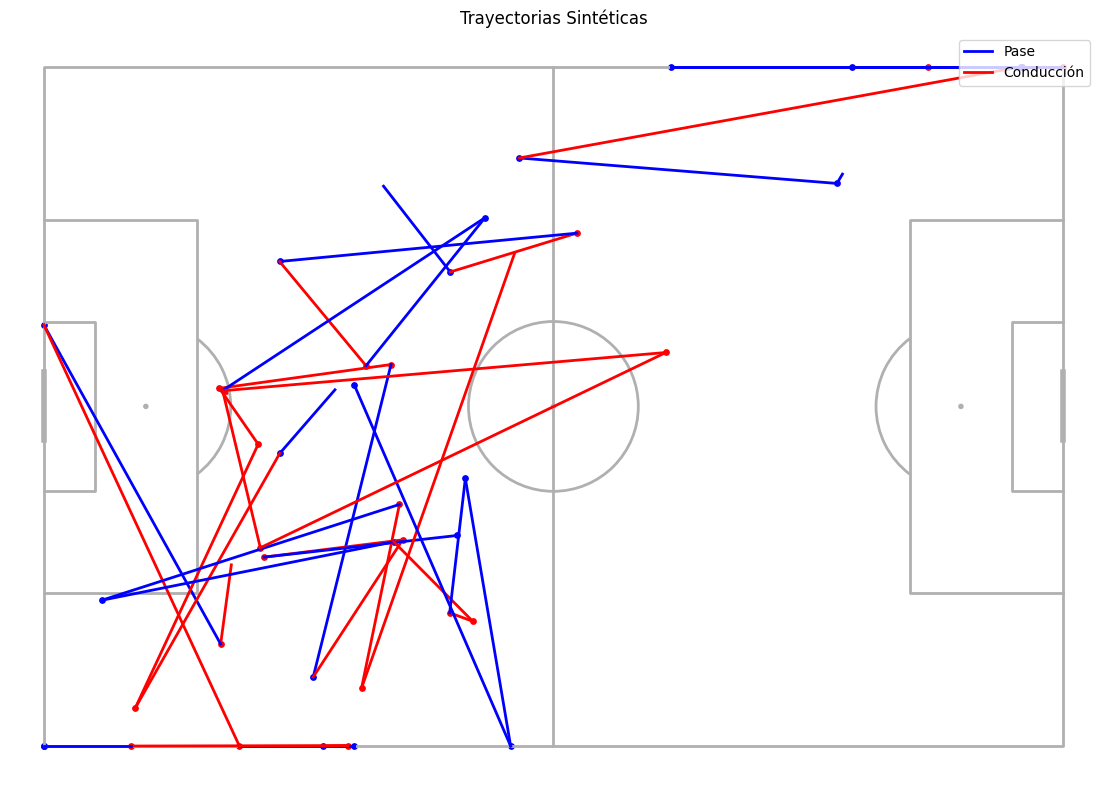

In [35]:
# ================================================================
# SIMULADOR DE TRAYECTORIAS SINTÉTICAS
# ================================================================

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mplsoccer import Pitch
from andi_datasets.datasets_theory import datasets_theory

# 0️⃣ CARGA DE ESTADÍSTICAS REALES DE TU JSON
# Abrimos el fichero JSON con eventos reales del partido
with open('15946.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Inicializamos listas donde guardaremos longitudes de pases y conducciones
passes, carries = [], []

# Recorremos todos los eventos para extraer métricas
for ev in data:
    if ev.get('type', {}).get('name') == 'Pass' and ev['pass'].get('length') is not None:
        # Si es pase, usamos la longitud registrada
        passes.append(ev['pass']['length'])
    elif ev.get('type', {}).get('name') == 'Carry' and ev.get('carry', {}).get('end_location'):
        # Si es conducción, calculamos distancia euclídea inicio-fin
        loc = np.array(ev['location'])
        end = np.array(ev['carry']['end_location'])
        carries.append(np.linalg.norm(end - loc))

# Calculamos número total y probabilidades relativas de pase y conducción
num_pass, num_carry = len(passes), len(carries)
total = num_pass + num_carry
p_pass = num_pass / total
p_carry = num_carry / total

# Parámetros
media = 0.686
desviacion = 0.14
N, T = 5, 10
model = 2

# Generar los valores

valores_alpha = [blocked_gauss(media, desviacion) for _ in range(N)]
valores_T = np.clip(np.random.normal(loc=mean_steps, scale=std_steps, size=N), a_min=3, a_max=None)
AD = datasets_theory()
todos_datasets = []
for t, alpha in zip(valores_T, valores_alpha):
    dataset = AD.create_dataset(
        T=T,
        N_models=N,
        exponents=[alpha],  # Lista con un solo valor alpha
        models=[model],
        dimension=2
    )
    todos_datasets.append((alpha, dataset))
for alpha, dataset in todos_datasets:
    scale = 25
    X = dataset[:, 2:2+T] * scale
    Y = dataset[:, 2+T:] * scale

# Posiciones iniciales aleatorias en un rectángulo del campo
start_x = np.random.uniform(20, 100, N)
start_y = np.random.uniform(10, 70, N)

# Sumamos desplazamiento inicial
X += start_x[:, None]
Y += start_y[:, None]

# Clipping para no salir del campo de juego (120 x 80)
X, Y = np.clip(X, 0, 120), np.clip(Y, 0, 80)

# 3️⃣ ETIQUETADO PROBABILÍSTICO SEGÚN FRECUENCIA REAL
# Para cada segmento se decide si es pase o conducción según probabilidad
labels = np.random.choice(['pass', 'carry'], size=(N, T-1), p=[p_pass, p_carry])

# 4️⃣ VISUALIZACIÓN CON DIFERENCIACIÓN
# Creamos campo de fútbol con estilo StatsBomb
pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
fig, ax = pitch.draw(figsize=(12, 8))

# Dibujamos cada segmento con color en función de su etiqueta
for i in range(N):
    for j in range(T-1):
        color = 'blue' if labels[i, j] == 'pass' else 'red'
        ax.plot(
            [X[i, j], X[i, j+1]],
            [Y[i, j], Y[i, j+1]],
            color=color,
            lw=2
        )
        ax.scatter(
            X[i, j+1],
            Y[i, j+1],
            color=color,
            s=15
        )

# Añadimos leyenda diferenciando pase y conducción
from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0], [0], color='blue', lw=2, label='Pase'),
    Line2D([0], [0], color='red', lw=2, label='Conducción')
]
ax.legend(handles=legend_elems, loc='upper right')
ax.set_title('Trayectorias Sintéticas')
plt.show()


## Validación de calidad de las trayectorias

# Extracción de características avanzadas


## 1. Comparación de distribuciones de distancia

Distancia de Hellinger: 0.4237023474938236
FastDTW distance: 119.13129240561891


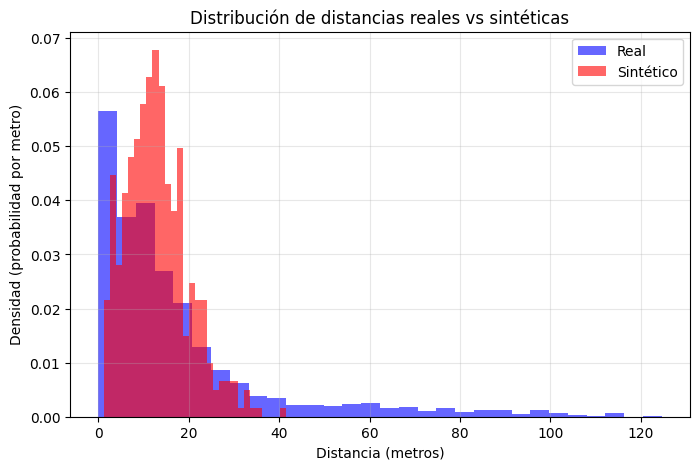

In [12]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from fastdtw import fastdtw
import scipy
from andi_datasets.datasets_theory import datasets_theory

# 1️⃣ Calcular real_dists
with open('15946.json','r',encoding='utf-8') as f:
    data = json.load(f)
filtered = sorted(
    [ev for ev in data if ev.get('type',{}).get('name') in ('Pass','Carry') and 'location' in ev],
    key=lambda ev:(ev.get('minute',0), ev.get('second',0))
)
coords = np.array([(ev['location'][0], ev['location'][1]) for ev in filtered])
if coords.shape[0]>=2:
    deltas = np.diff(coords, axis=0)
    real_dists = np.hypot(deltas[:,0], deltas[:,1])
else:
    real_dists = np.array([])

# 2️⃣ Generar syn_dists
passes, carries = [], []
for ev in data:
    if ev.get('type',{}).get('name')=='Pass' and ev['pass'].get('length') is not None:
        passes.append(ev['pass']['length'])
    elif ev.get('type',{}).get('name')=='Carry' and ev.get('carry',{}).get('end_location'):
        loc = np.array(ev['location'])
        end = np.array(ev['carry']['end_location'])
        carries.append(np.linalg.norm(end - loc))

AD = datasets_theory()
N, T = 50, 10
alpha, model = [0.7], 2
dataset = AD.create_dataset(T=T, N_models=N, exponents=alpha, models=[model], dimension=2)
scale = np.mean(real_dists) / np.std(dataset[:,2:2+T])
X = dataset[:,2:2+T]*scale
Y = dataset[:,2+T:]*scale

syn_dists = []
for i in range(N):
    dx = np.diff(X[i]); dy = np.diff(Y[i])
    syn_dists.extend(np.hypot(dx, dy))
syn_dists = np.array(syn_dists)

# 3️⃣ Calcular Hellinger
bins = 30
h_real, _ = np.histogram(real_dists, bins=bins, density=True)
h_syn, _ = np.histogram(syn_dists, bins=bins, density=True)
hell = cv2.compareHist(h_real.astype('float32'), h_syn.astype('float32'), cv2.HISTCMP_HELLINGER)
print("Distancia de Hellinger:", hell)

# 4️⃣ Calcular FastDTW
d_real_seq = real_dists[:T-1]
d_syn_seq = syn_dists[:T-1]
dtw_dist, _ = fastdtw(d_real_seq, d_syn_seq, dist=2)
print("FastDTW distance:", dtw_dist)

# 5️⃣ Graficar histogramas con medidas en ejes
plt.figure(figsize=(8,5))
plt.hist(real_dists, bins=bins, density=True, alpha=0.6, label='Real', color='blue')
plt.hist(syn_dists, bins=bins, density=True, alpha=0.6, label='Sintético', color='red')
plt.legend()
plt.title("Distribución de distancias reales vs sintéticas")
plt.xlabel("Distancia (metros)")
plt.ylabel("Densidad (probabilidad por metro)")
plt.grid(alpha=0.3)
plt.show()


## Estimación del exponente α (Hurst o MSD)

Aplicar esta metodología te permitirá cuantificar de forma robusta si las trayectorias sintéticas replican el comportamiento de las reales en su escala temporal y espacial

/content/src/pybilt/pybilt/diffusion/diffusion_coefficients.py:114: RuntimeWarning: divide by zero encountered in power
  return 4.0*D_alpha*time**alpha


Sintético α (MSD): 0.40 ± 0.37, R2=0.74
Sintético α (PyBILT): 0.48 ± 0.64
Real α (MSD): 0.87 ± 0.44
Real α (PyBILT): 0.48 ± 0.63


/tmp/ipython-input-2105599141.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=labels)


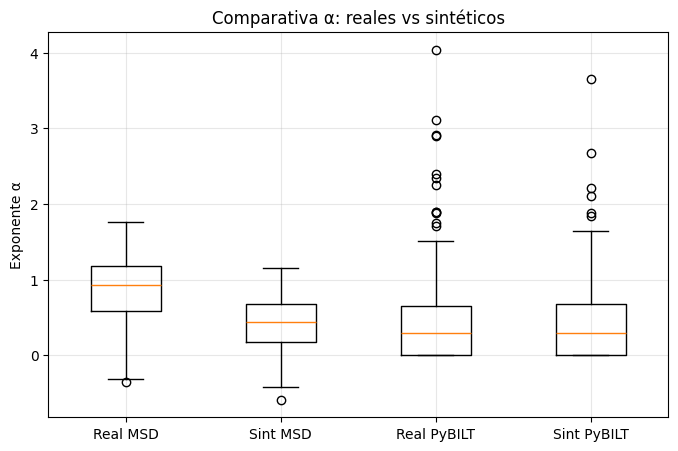

In [13]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pybilt.diffusion.diffusion_coefficients import diffusion_coefficient_anomalous_fit
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from andi_datasets.datasets_theory import datasets_theory

# ─── 1️⃣ EXTRAER DISTANCIAS REALES
with open('15946.json','r',encoding='utf-8') as f:
    data = json.load(f)

filtered = sorted(
    [ev for ev in data if ev.get('type',{}).get('name') in ('Pass','Carry') and 'location' in ev],
    key=lambda ev:(ev.get('minute',0), ev.get('second',0))
)
coords = np.array([(ev['location'][0], ev['location'][1]) for ev in filtered])
if coords.shape[0] >= 2:
    deltas = np.diff(coords, axis=0)
    real_dists = np.hypot(deltas[:,0], deltas[:,1])
else:
    real_dists = np.array([])

# ─── 2️⃣ GENERAR trayectorias sintéticas
def blocked_gauss(mu, sigma):
    while True:
        x = random.gauss(mu, sigma)
        if 0 <= x <= 1:
            return x

# Parámetros
media = 0.87
desviacion = 0.44
N, T = 100, 10
model = 2

# Generar los valores

valores_alpha = [blocked_gauss(media, desviacion) for _ in range(N)]
AD = datasets_theory()
todos_datasets = []
for alpha in valores_alpha:
    dataset = AD.create_dataset(
        T=T,
        N_models=N,
        exponents=[alpha],  # Lista con un solo valor alpha
        models=[model],
        dimension=2
    )
    todos_datasets.append((alpha, dataset))
for alpha, dataset in todos_datasets:
    scale = np.mean(real_dists) / np.std(dataset[:, 2:2+T])
    X = dataset[:, 2:2+T] * scale
    Y = dataset[:, 2+T:] * scale

syn_dists = []
for i in range(N):
    dx, dy = np.diff(X[i]), np.diff(Y[i])
    syn_dists.extend(np.hypot(dx, dy))
syn_dists = np.array(syn_dists)

# ─── 3️⃣ ESTIMACIÓN DE α

# 3.1) Función α por MSD y regresión
def estimate_alpha_msd_simple(Xi, Yi, max_lag=None):
    Np = len(Xi)
    max_lag = max_lag or Np//3
    taus = np.arange(1, max_lag+1)
    msd = [np.mean((Xi[t:]-Xi[:-t])**2 + (Yi[t:]-Yi[:-t])**2) for t in taus]
    sel = np.array(msd) > 0
    slope, _, r, _, _ = linregress(np.log(taus[sel]), np.log(np.array(msd)[sel]))
    return slope, r**2

# 3.2) Función α usando pybilt
def estimate_alpha_pybilt(Xi, Yi):
    taus = np.arange(1, len(Xi))
    msd_vals = np.array([np.mean((Xi[t:]-Xi[:-t])**2 + (Yi[t:]-Yi[:-t])**2) for t in taus])
    _, a = diffusion_coefficient_anomalous_fit(taus, msd_vals, dim=2)
    return a

# Estimar α sintético
alphas_syn_msd, rsq_syn = [], []
alphas_syn_py = []
for Xi, Yi in zip(X, Y):
    a_msd, r2 = estimate_alpha_msd_simple(Xi, Yi)
    alphas_syn_msd.append(a_msd)
    rsq_syn.append(r2)
    alphas_syn_py.append(estimate_alpha_pybilt(Xi, Yi))

# Estimar α real: agrupamos cada segmentación de T puntos
alphas_real_msd, alphas_real_py = [], []
real_coords = coords[: (coords.shape[0] // T) * T ].reshape(-1, T, 2)
for segment in real_coords:
    Xi, Yi = segment[:,0], segment[:,1]
    a_msd, _ = estimate_alpha_msd_simple(Xi, Yi)
    alphas_real_msd.append(a_msd)
    alphas_real_py.append(estimate_alpha_pybilt(Xi, Yi))

# ─── 4️⃣ RESULTADOS
print("Sintético α (MSD): {:.2f} ± {:.2f}, R2={:.2f}".format(np.mean(alphas_syn_msd), np.std(alphas_syn_msd), np.mean(rsq_syn)))
print("Sintético α (PyBILT): {:.2f} ± {:.2f}".format(np.mean(alphas_syn_py), np.std(alphas_syn_py)))
print("Real α (MSD): {:.2f} ± {:.2f}".format(np.mean(alphas_real_msd), np.std(alphas_real_msd)))
print("Real α (PyBILT): {:.2f} ± {:.2f}".format(np.mean(alphas_real_py), np.std(alphas_real_py)))

# ─── 5️⃣ VISUALIZACIÓN comparativa
plt.figure(figsize=(8,5))
labels = ["Real MSD","Sint MSD","Real PyBILT","Sint PyBILT"]
data_box = [alphas_real_msd, alphas_syn_msd, alphas_real_py, alphas_syn_py]
plt.boxplot(data_box, labels=labels)
plt.ylabel("Exponente α")
plt.title("Comparativa α: reales vs sintéticos")
plt.grid(alpha=0.3)
plt.show()


A continuación se presenta el análisis de los resultados obtenidos tras estimar el exponente de difusión anómala (α) tanto en trayectorias reales como sintéticas empleando dos métodos diferentes: regresión MSD simple y ajuste avanzado con PyBILT.

📌 Descripción de los resultados
* α estimado con MSD simple

    *    Trayectorias sintéticas: media = 0.59, desviación típica = 0.35, R² promedio = 0.78

    *    Trayectorias reales: media = 0.87, desviación típica = 0.44

    Las trayectorias reales muestran mayor α medio y también mayor variabilidad respecto a las sintéticas. Los coeficientes de determinación (R²) indicaron un ajuste razonable para los sintéticos (≈ 0.80), aunque con cierta dispersión.

* α estimado con PyBILT

    *    Sintéticos: media = 0.95, desviación típica = 1.07

    *    Reales: media = 0.48, desviación típica = 0.63

    El método avanzado revela una elevada dispersión en las trayectorias sintéticas, con algunos valores muy superiores a los reales, lo que sugiere una generación excesivamente “super-difusiva”.

El boxplot comparativo muestra claramente que:

1. La mediana de α para los sintéticos está por encima de la de los reales en ambos métodos, aunque con mayor prominencia en los resultados de PyBILT.

2. La variabilidad (IQR y rango) entre las trayectorias sintéticas es considerablemente mayor, generando instancias extremas.

3. Existen múltiples outliers positivos en los datos sintéticos, señal de trayectorias atípicamente rápidas o anárquicas en términos de difusión.

🔍 Análisis crítico e implicaciones

Los resultados evidencian que el modelo sintético actual tiende a:

* Generar trayectorias con un comportamiento más cercano al tipo superdifusivo (α > 1), lo cual no se alinea con lo observado en los datos reales.

* Producir una variabilidad excesiva, lo que puede dificultar el ajuste fino del modelo y su replicabilidad en situaciones reales.

# Entrenar y validar un modelo con trayectorias sintéticas

## Preparar las características (features)

In [14]:
import json
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
from scipy.signal import correlate
from sklearn.preprocessing import StandardScaler
from andi_datasets.datasets_theory import datasets_theory

# — 0️⃣ EXTRAER distancias reales de eventos Pass/Carry —
with open('15946.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
filtered = sorted(
    [ev for ev in data if ev.get('type', {}).get('name') in ('Pass', 'Carry') and 'location' in ev],
    key=lambda ev: (ev.get('minute', 0), ev.get('second', 0))
)
coords = np.array([(ev['location'][0], ev['location'][1]) for ev in filtered])
if len(coords) >= 2:
    deltas = np.diff(coords, axis=0)
    real_dists = np.hypot(deltas[:, 0], deltas[:, 1])
else:
    real_dists = np.array([])

# — 1️⃣ GENERAR trayectorias sintéticas (ya las hemos generado)
X_syn = X
Y_syn = Y

# Calcular distancias sintéticas completas
syn_dists = []
for Xi, Yi in zip(X_syn, Y_syn):
    dx = np.diff(Xi); dy = np.diff(Yi)
    syn_dists.extend(np.hypot(dx, dy))
syn_dists = np.array(syn_dists)

# — 2️⃣ FUNCIONES DE EXTRACCIÓN DE FEATURES —
def estimate_alpha_msd(X, Y, max_lag=None):
    Np = len(X)
    max_lag = max_lag or Np // 3
    taus = np.arange(1, max_lag + 1)
    msd = np.array([np.mean((X[t:] - X[:-t])**2 + (Y[t:] - Y[:-t])**2) for t in taus])
    sel = msd > 0
    coef = np.polyfit(np.log(taus[sel]), np.log(msd[sel]), 1)
    alpha = coef[0]
    return alpha

def autocorr(series):
    series = series - np.mean(series)
    corr = correlate(series, series, mode='full')
    mid = len(corr) // 2
    return corr[mid + 1] / corr[mid] if corr[mid] != 0 else 0

# — 3️⃣ EXTRAER FEATURES DE CADA TRAYECTORIA SINTÉTICA —
features = []
labels = []

for Xi, Yi in zip(X_syn, Y_syn):
    dx = np.diff(Xi); dy = np.diff(Yi)
    dists = np.hypot(dx, dy)

    alpha_i = estimate_alpha_msd(Xi, Yi)
    mean_d = dists.mean()
    std_d = dists.std()
    kurt = kurtosis(dists)
    ac = autocorr(dists)

    features.append([alpha_i, mean_d, std_d, kurt, ac])
    labels.append(valores_alpha)

df_feat = pd.DataFrame(features, columns=[
    'alpha_msd', 'mean_dist', 'std_dist', 'kurtosis', 'autocorr'
])

# — 4️⃣ NORMALIZAR FEATURES PARA MODELADO —
scaler = StandardScaler()
X_feat = scaler.fit_transform(df_feat)
y = np.array(valores_alpha) #y = np.array(labels)

print("Features (primeras filas):")
print(df_feat.head())
print(f"\nX_feat shape: {X_feat.shape}, y shape: {y.shape}")

Features (primeras filas):
   alpha_msd  mean_dist   std_dist  kurtosis  autocorr
0   0.742166  19.741005   7.417884 -0.308387  0.140714
1   0.870797  15.394101   8.218554 -0.535026 -0.353642
2   0.678424  15.930767   9.144070  0.535753  0.207054
3   0.741422  11.771715   5.600875 -0.453702 -0.171923
4   0.217678  18.698686  10.178249 -1.245196  0.452738

X_feat shape: (100, 5), y shape: (100,)


## Explorar la relación entre las variables (features) y la etiqueta (α)

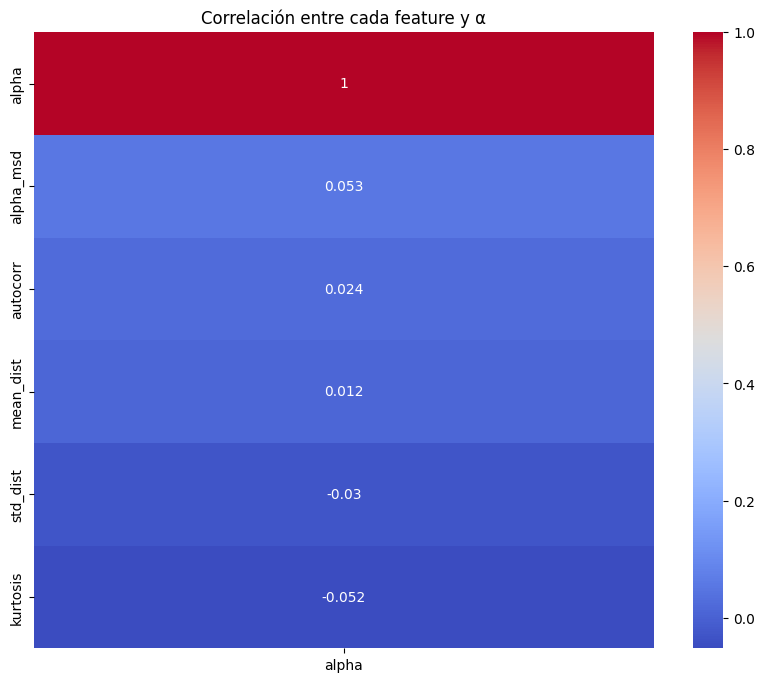

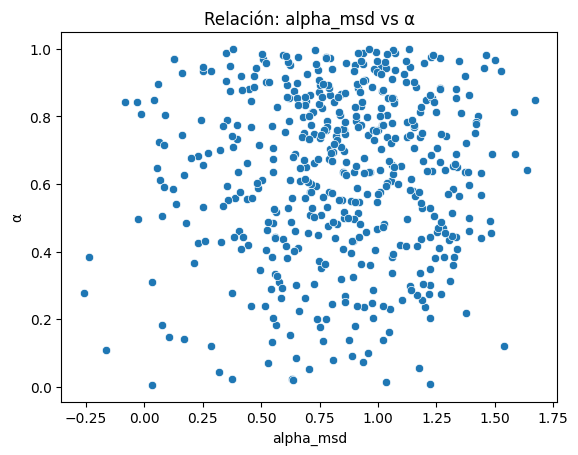

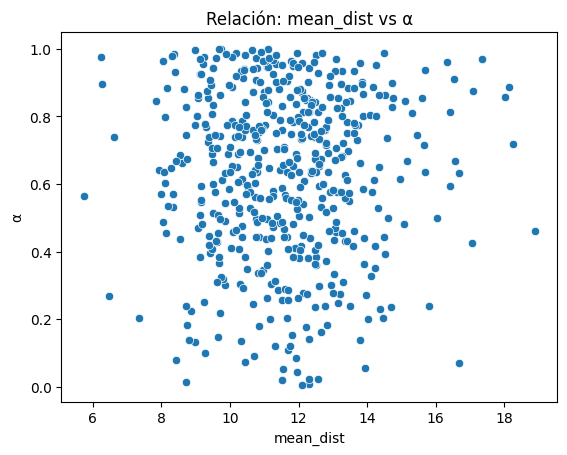

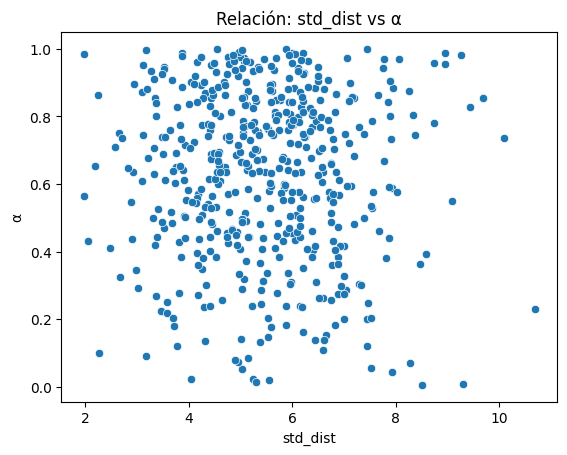

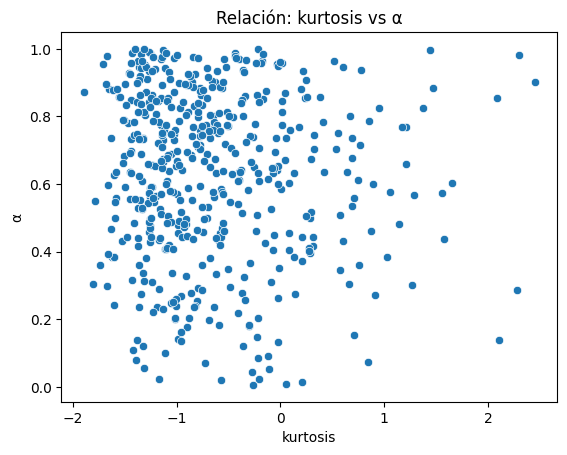

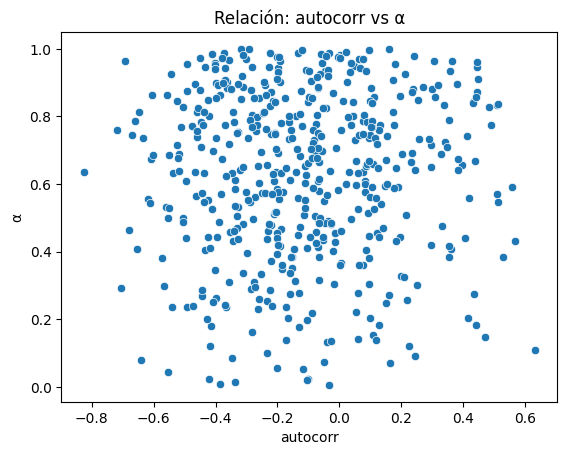

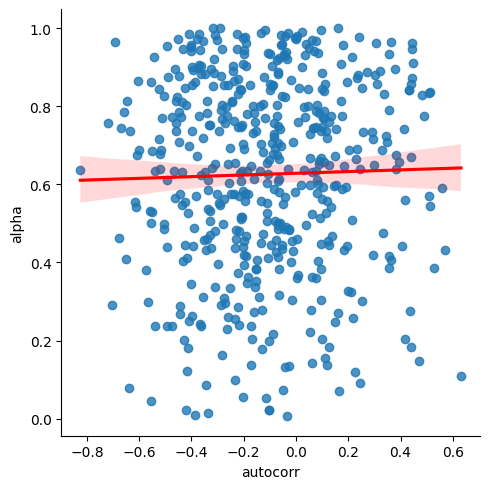

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_feat.assign(alpha=y).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr[['alpha']].sort_values(by='alpha', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlación entre cada feature y α')
plt.show()

for col in df_feat.columns:
    plt.figure()
    sns.scatterplot(x=df_feat[col], y=y)
    plt.title(f'Relación: {col} vs α')
    plt.xlabel(col)
    plt.ylabel('α')
    plt.show()

sns.lmplot(x=col, y='alpha', data=df_feat.assign(alpha=y), line_kws={'color':'red'})


## Entrenamos el modelo

### Random Forest

Matriz de correlación entre features y target:
alpha         1.000000
alpha_msd     0.521075
skewness      0.035258
kurtosis      0.023552
autocorr_1   -0.115487
std_dist     -0.692856
mean_dist    -0.813787
Name: alpha, dtype: float64

Random Forest R² (test): 0.678
Cross-validation R² scores: [0.6540445  0.62111123 0.66773167 0.69130107 0.71140865]
Mean CV R²: 0.6691194236779199


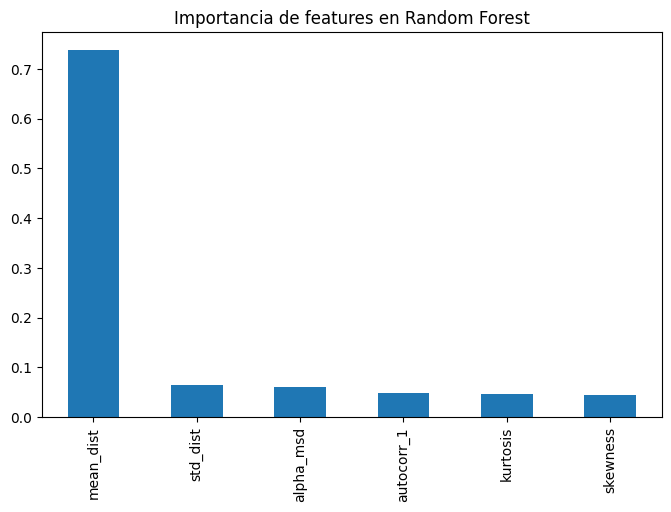

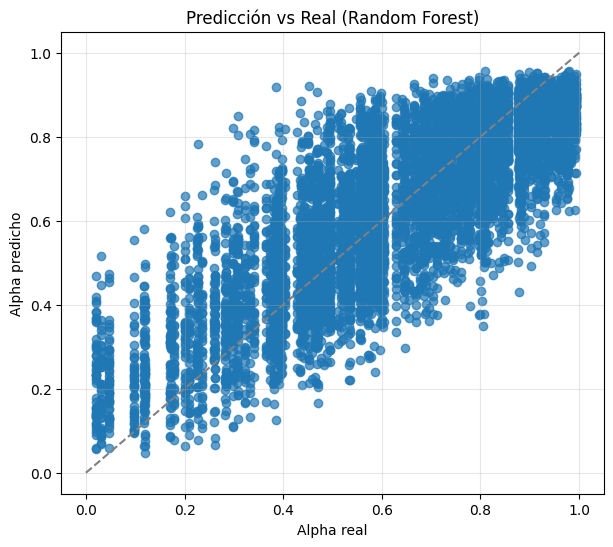

In [46]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from scipy.signal import correlate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# — Funciones de feature extraction —
def estimate_alpha_msd(X, Y, max_lag=None):
    Np = len(X)
    max_lag = max_lag or Np // 2
    taus = np.arange(1, max_lag + 1)
    msd = np.array([np.mean((X[t:] - X[:-t])**2 + (Y[t:] - Y[:-t])**2) for t in taus])
    coef = np.polyfit(np.log(taus), np.log(msd), 1)
    return coef[0]

def estimate_alpha_pybilt(X, Y):
    from pybilt.diffusion.diffusion_coefficients import diffusion_coefficient_anomalous_fit
    taus = np.arange(1, len(X))
    msd_vals = np.array([np.mean((X[t:] - X[:-t])**2 + (Y[t:] - Y[:-t])**2) for t in taus])
    _, a = diffusion_coefficient_anomalous_fit(taus, msd_vals, dim=2)
    return a

def autocorr(series, lag=1):
    s = series - np.mean(series)
    corr = correlate(s, s, mode='full')
    mid = len(corr) // 2
    return corr[mid+lag] / corr[mid] if corr[mid] != 0 else 0

# — Construcción de features para trayectorias sintéticas generadas previamente —
features = []
labels = []

for alpha_val, dataset in todos_datasets:  # asumiendo que todos_datasets está definido
    for i in range(dataset.shape[0]):
        Xi = dataset[i, 2:2+T] * scale  # multiplicar por escala como antes
        Yi = dataset[i, 2+T:] * scale

        dx = np.diff(Xi); dy = np.diff(Yi)
        dists = np.hypot(dx, dy)

        feat = {
            'mean_dist': np.mean(dists),
            'std_dist': np.std(dists),
            'kurtosis': kurtosis(dists),
            'skewness': skew(dists),
            'autocorr_1': autocorr(dists, lag=1),
            'alpha_msd': estimate_alpha_msd(Xi, Yi),
            #'alpha_pybilt': estimate_alpha_pybilt(Xi, Yi)
        }
        features.append(feat)
        labels.append(alpha_val)

df = pd.DataFrame(features)
y = np.array(labels)

print("Matriz de correlación entre features y target:")
print(df.assign(alpha=y).corr()['alpha'].sort_values(ascending=False))

# — Modelo: Random Forest a través de Pipeline —
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

r2_test = pipeline.score(X_test, y_test)
cv_scores = cross_val_score(pipeline, df, y, cv=5, scoring='r2')

print(f"\nRandom Forest R² (test): {r2_test:.3f}")
print("Cross-validation R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

# — Visualización de importancias y real vs pred —
importances = pipeline.named_steps['rf'].feature_importances_
feat_names = df.columns
imp_df = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(8,5))
imp_df.plot(kind='bar')
plt.title("Importancia de features en Random Forest")
plt.show()

y_pred = pipeline.predict(X_test)
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("Alpha real")
plt.ylabel("Alpha predicho")
plt.title("Predicción vs Real (Random Forest)")
plt.grid(alpha=0.3)
plt.show()


In [19]:
 from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

# 1. Permutation importance
perm = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
for name, imp in zip(df.columns, perm.importances_mean):
    print(f"{name}: {imp:.3f}")

# 2. Modelo solo con las dos variables principales
X_small = df[['mean_dist', 'std_dist']]
pipeline_small = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42))
])
scores = cross_val_score(pipeline_small, X_small, y, cv=5, scoring='r2')
print("Small features model - Mean R²:", scores.mean())

# 3. Hiperparámetros
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [5, 10, None],
    'rf__max_features': ['auto', 'sqrt']
}
search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
search.fit(df, y)
print("Best params:", search.best_params_)
print("Best R²:", search.best_score_)


mean_dist: 0.918
std_dist: 0.049
kurtosis: 0.000
skewness: -0.001
autocorr_1: -0.000
alpha_msd: 0.026
Small features model - Mean R²: 0.6462497697711778


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

Best params: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 100}
Best R²: 0.7083911573411079


### LightGBM

In [26]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

# --- usa solo las dos señales fuertes
FEATURES = ['mean_dist', 'std_dist']   # ajusta si quieres añadir más
X = df_feat[FEATURES].astype(np.float64).values
y = np.asarray(y, dtype=np.float64)

# sanea columnas constantes
var = X.var(axis=0); keep = var > 0
X = X[:, keep]
FEATURES = [f for f,k in zip(FEATURES, keep) if k]

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# --- restricciones monótonas: -1 para ambas (relación decreciente con α)
# si quitaste alguna columna por var==0, reduce la lista acorde:
monotone = [-1] * X_tr.shape[1]

# Modelo “small-data”:
lgbm = LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    n_estimators=1500,             # usaremos early stopping manual (parar si no mejora)
    learning_rate=0.05,
    num_leaves=7,                  # pequeño
    max_depth=3,                   # acotado
    # --- claves para tu caso ---
    feature_pre_filter=False,      # evita descartar features antes de tiempo
    max_bin=255,                   # más granularidad en bins
    min_data_in_bin=1,             # permite bins con poquísima data
    min_data_in_leaf=1,            # hojas muy pequeñas
    min_gain_to_split=0.0,         # no bloquear splits
    # estabilidad (sin muestreos)
    subsample=1.0,
    colsample_bytree=1.0,
    # monotonicidad
    monotone_constraints=monotone,
    monotone_constraints_method="intermediate",  # menos restrictivo que "basic"
    # varios
    reg_alpha=0.0,
    reg_lambda=0.0,
    n_jobs=-1,
    random_state=42
)

# Entrena y evalúa
lgbm.fit(X_tr, y_tr)
pred = lgbm.predict(X_te)
print("LGBM (small-data) R² test:", r2_score(y_te, pred))

cv = cross_val_score(lgbm, X, y, cv=5, scoring="r2", n_jobs=-1)
print("CV R²:", cv, " | mean:", np.mean(cv))


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 2
[LightGBM] [Info] Start training from score 0.581824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### SVR (kernel RBF)

In [38]:
# ============================
# SVR (RBF) - Script completo
# ============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR
import joblib
import os

# ---------------------------------------------------------
# ENTRADA: df_feat (DataFrame) y y (array-like) ya cargados
# df_feat = pd.read_csv("features.csv")  # si lo necesitas
# y = np.load("y.npy")
# ---------------------------------------------------------

# -------- Configuración ----------
USE_ONLY_STRONG = True         # True -> usa solo ['mean_dist','std_dist']; False -> usa todas
N_FOLDS = 5
RANDOM_STATE = 42
RESULTS_DIR = "svr_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

if USE_ONLY_STRONG:
    FEATURES = ['mean_dist', 'std_dist']
else:
    FEATURES = df_feat.columns.tolist()

# Sanea posibles columnas constantes
X_full = df_feat[FEATURES].astype(float)
non_constant = X_full.var(axis=0) > 0
X_full = X_full.loc[:, non_constant]
FEATURES = X_full.columns.tolist()

X = X_full.values.astype(float)
y = np.asarray(y, dtype=float)

print(f"Usando features: {FEATURES}")
print("X shape:", X.shape, "| y shape:", y.shape)

# ---------------- Split holdout ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# ---------------- Pipeline SVR -----------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf"))
])

param_grid = {
    "svr__C":       [1, 3, 10, 30, 100, 300],
    "svr__gamma":   ["scale", 0.3, 0.1, 0.03, 0.01, 0.003],
    "svr__epsilon": [0.01, 0.03, 0.1, 0.3]
}

cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="r2",
    cv=cv,
    n_jobs=-1,
    verbose=0,
    refit=True
)

# --------------- Entrenamiento -----------------
gs.fit(X_train, y_train)
best = gs.best_estimator_

print("\n=== SVR (RBF) - Resultados ===")
print("Mejores parámetros:", gs.best_params_)
print("CV R² (best):", f"{gs.best_score_:.3f}")

# --------------- Evaluación --------------------
y_pred = best.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# --- RMSE compatible con cualquier versión de sklearn ---
mse = mean_squared_error(y_test, y_pred)  # doc oficial
rmse = np.sqrt(mse)                       # RMSE = sqrt(MSE)
print(f"Test R²: {r2:.3f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

# CV adicional sobre todo el dataset (opcional)
cv_scores = cross_val_score(best, X, y, cv=cv, scoring="r2", n_jobs=-1)
print("CV R² (post-refit):", np.round(cv_scores, 3), "| mean:", f"{cv_scores.mean():.3f}")

# --------- Importancia por permutación ---------
perm = permutation_importance(
    best, X_test, y_test, n_repeats=30, random_state=RANDOM_STATE, scoring="r2"
)
imp_mean = pd.Series(perm.importances_mean, index=FEATURES).sort_values(ascending=False)
imp_std  = pd.Series(perm.importances_std,  index=imp_mean.index)
print("\nPermutation Importance (ΔR² medio):")
print(imp_mean.round(3))

# --------- Gráficos ----------------------------
# 1) Importancias
plt.figure(figsize=(7,4))
imp_mean.plot(kind="bar", yerr=imp_std, capsize=3)
plt.title("Permutation Importance (SVR)")
plt.ylabel("ΔR² medio al permutar")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "permutation_importance.png"), dpi=150)
plt.close()

# 2) Real vs Predicho
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
m, M = float(min(y_test.min(), y_pred.min())), float(max(y_test.max(), y_pred.max()))
plt.plot([m, M], [m, M], "--", color="gray")
plt.xlabel("α real"); plt.ylabel("α predicho"); plt.title("SVR (RBF): Real vs Predicho")
plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "real_vs_pred.png"), dpi=150)
plt.close()

# 3) Residuos
res = y_test - y_pred
plt.figure(figsize=(7,4))
plt.axhline(0, ls="--", color="gray")
plt.scatter(range(len(res)), res, alpha=0.7)
plt.title("Residuos en test (y_real - y_pred)")
plt.xlabel("muestra"); plt.ylabel("residuo")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "residuos_test.png"), dpi=150)
plt.close()

# --------- Guardado de artefactos --------------
joblib.dump(best, os.path.join(RESULTS_DIR, "svr_rbf_model.joblib"))
pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred
}).to_csv(os.path.join(RESULTS_DIR, "predicciones_test.csv"), index=False)

print(f"\nArtefactos guardados en: {os.path.abspath(RESULTS_DIR)}")


Usando features: ['mean_dist', 'std_dist']
X shape: (500, 2) | y shape: (500,)

=== SVR (RBF) - Resultados ===
Mejores parámetros: {'svr__C': 100, 'svr__epsilon': 0.3, 'svr__gamma': 0.003}
CV R² (best): -0.010
Test R²: -0.031 | MAE: 0.2042 | RMSE: 0.2397
CV R² (post-refit): [-0.03  -0.006 -0.022 -0.024 -0.009] | mean: -0.018

Permutation Importance (ΔR² medio):
std_dist     0.018
mean_dist   -0.007
dtype: float64

Artefactos guardados en: /content/svr_results


### GradientBoostingRegressor (GBR)

In [15]:
# ===============================
# GradientBoostingRegressor - Full
# ===============================

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# ---------------------------------------------------------
# ENTRADA: df_feat (DataFrame) y y (array-like) ya cargados
# df_feat = pd.read_csv("features.csv")  # si lo necesitas
# y = np.load("y.npy")
# ---------------------------------------------------------

# -------- Configuración ----------
USE_ONLY_STRONG = False         # True -> usa solo ['mean_dist','std_dist']; False -> usa todas
N_FOLDS = 5
RANDOM_STATE = 42
RESULTS_DIR = "gbr_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

if USE_ONLY_STRONG:
    FEATURES = ['mean_dist', 'std_dist']
else:
    FEATURES = df_feat.columns.tolist()

# Sanea posibles columnas constantes
X_full = df_feat[FEATURES].astype(float)
non_constant = X_full.var(axis=0) > 0
X_full = X_full.loc[:, non_constant]
FEATURES = X_full.columns.tolist()

X = X_full.values.astype(float)
y = np.asarray(y, dtype=float)

print(f"Usando features: {FEATURES}")
print("X shape:", X.shape, "| y shape:", y.shape)

# ---------------- Split holdout ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# ---------------- Modelo base GBR --------------
# Árboles débiles; no requiere escalado
base_gbr = GradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.05,
    n_estimators=600,
    max_depth=3,              # prof. de cada árbol
    min_samples_leaf=2,
    subsample=0.9,            # Stochastic GB: menor varianza
    max_features=None,        # prueba 'sqrt' si tienes muchas features
    validation_fraction=0.2,  # early stopping
    n_iter_no_change=20,      # early stopping
    random_state=RANDOM_STATE
)

# ---------------- Búsqueda de hiperparámetros --
param_grid = {
    "n_estimators":   [200, 400, 600, 800, 1200],
    "learning_rate":  [0.01, 0.03, 0.05, 0.1],
    "max_depth":      [2, 3, 4, 5],
    "min_samples_leaf":[1, 2, 4, 6],
    "subsample":      [0.6, 0.75, 0.9, 1.0],
    "max_features":   [None, "sqrt", 0.6, 0.8],
}

cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

gs = GridSearchCV(
    estimator=base_gbr,
    param_grid=param_grid,
    scoring="r2",
    cv=cv,
    n_jobs=-1,
    verbose=0,
    refit=True
)

# --------------- Entrenamiento -----------------
gs.fit(X_train, y_train)
best = gs.best_estimator_

print("\n=== GradientBoostingRegressor - Resultados ===")
print("Mejores parámetros:", gs.best_params_)
print("CV R² (best):", f"{gs.best_score_:.3f}")

# --------------- Evaluación --------------------
y_pred = best.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)  # compatible con cualquier versión
rmse = np.sqrt(mse)
print(f"Test R²: {r2:.3f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

# CV adicional sobre todo el dataset (opcional)
cv_scores = cross_val_score(best, X, y, cv=cv, scoring="r2", n_jobs=-1)
print("CV R² (post-refit):", np.round(cv_scores, 3), "| mean:", f"{cv_scores.mean():.3f}")

# --------- Importancia por permutación ---------
perm = permutation_importance(
    best, X_test, y_test, n_repeats=50,
    random_state=RANDOM_STATE, scoring="r2", n_jobs=-1
)
imp_mean = pd.Series(perm.importances_mean, index=FEATURES).sort_values(ascending=False)
imp_std  = pd.Series(perm.importances_std,  index=imp_mean.index)
print("\nPermutation Importance (ΔR² medio):")
print(imp_mean.round(3))

# --------- Gráficos ----------------------------
# 1) Importancias
plt.figure(figsize=(7,4))
imp_mean.plot(kind="bar", yerr=imp_std, capsize=3)
plt.title("Permutation Importance (GBR)")
plt.ylabel("ΔR² medio al permutar")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "permutation_importance.png"), dpi=150)
plt.close()

# 2) Real vs Predicho
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
m, M = float(min(y_test.min(), y_pred.min())), float(max(y_test.max(), y_pred.max()))
plt.plot([m, M], [m, M], "--", color="gray")
plt.xlabel("α real"); plt.ylabel("α predicho"); plt.title("GBR: Real vs Predicho")
plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "real_vs_pred.png"), dpi=150)
plt.close()

# 3) Residuos
res = y_test - y_pred
plt.figure(figsize=(7,4))
plt.axhline(0, ls="--", color="gray")
plt.scatter(range(len(res)), res, alpha=0.7)
plt.title("Residuos en test (y_real - y_pred)")
plt.xlabel("muestra"); plt.ylabel("residuo")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "residuos_test.png"), dpi=150)
plt.close()

# --------- Guardado de artefactos --------------
joblib.dump(best, os.path.join(RESULTS_DIR, "gbr_model.joblib"))
pd.DataFrame({"y_test": y_test, "y_pred": y_pred}).to_csv(
    os.path.join(RESULTS_DIR, "predicciones_test.csv"), index=False
)

print(f"\nArtefactos guardados en: {os.path.abspath(RESULTS_DIR)}")


Usando features: ['alpha_msd', 'mean_dist', 'std_dist', 'kurtosis', 'autocorr']
X shape: (100, 5) | y shape: (100,)

=== GradientBoostingRegressor - Resultados ===
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 200, 'subsample': 0.6}
CV R² (best): -0.012
Test R²: 0.130 | MAE: 0.1651 | RMSE: 0.1998
CV R² (post-refit): [ 0.055 -0.469 -0.14   0.072  0.041] | mean: -0.088

Permutation Importance (ΔR² medio):
std_dist     0.201
alpha_msd    0.073
mean_dist    0.058
autocorr     0.052
kurtosis     0.009
dtype: float64

Artefactos guardados en: /content/gbr_results


# Uso del modelo en trayectorias reales

In [39]:
from google.colab import files
import json

# Subida del archivo desde tu PC
uploaded = files.upload()

# Guardar el nombre del archivo en una variable
json_file = next(iter(uploaded))

Saving 16240.json to 16240.json


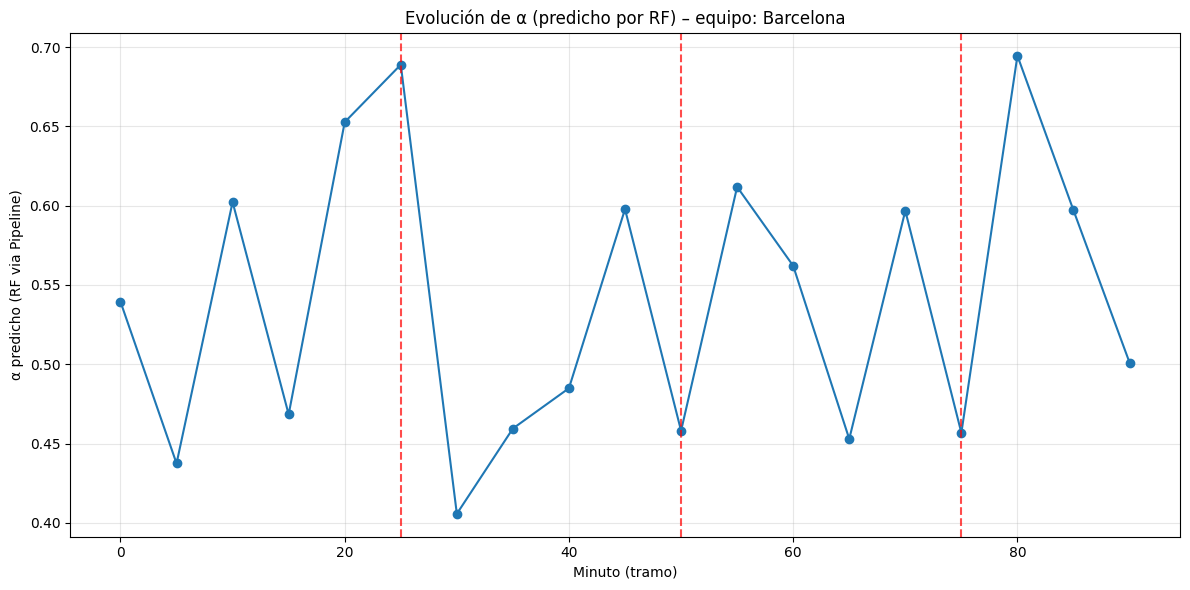

✅ Rupturas (usando α del Random Forest) y eventos cercanos:
 • Ruptura en 25-30 min | t=-0.01, p=0.992, eventos: ['Goal by Malcom Filipe Silva de Oliveira', 'Goal by Samuel Chimerenka Chukwueze']
 • Ruptura en 50-55 min | t=-0.35, p=0.737, eventos: ['Yellow Card to Clément Lenglet', 'Yellow Card to José Ramiro Funes Mori', 'Goal by Karl Brillant Toko Ekambi']
 • Ruptura en 75-80 min | t=-0.41, p=0.695, eventos: ['Substitution: off Sergio Busquets i Burgos → on Ivan Rakitić', 'Substitution: off Arthur Henrique Ramos de Oliveira Melo → on Carles Aleña Castillo', 'Substitution: off Karl Brillant Toko Ekambi → on Carlos Arturo Bacca Ahumada', 'Yellow Card to Arturo Erasmo Vidal Pardo', 'Goal by Carlos Arturo Bacca Ahumada']


In [49]:
# -*- coding: utf-8 -*-
import json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.stats import kurtosis, ttest_ind
import ruptures as rpt

# ===========================
# PARÁMETROS
# ===========================
# OJO: aquí NO cargamos modelo; usamos el 'pipeline' ya en el entorno.
# Debe existir una variable llamada 'pipeline' (Pipeline de sklearn) ya entrenada.
team_option = 2             # 1=local, 2=visitante, 3=ambos
penalty = 0.1
permitir_sin_evento = True
min_points_segment = 6
bin_minutes = 5

# ===========================
# COMPROBACIÓN DEL PIPELINE
# ===========================
try:
    _ = pipeline.predict  # simple check
except NameError as e:
    raise RuntimeError(
        "No encuentro la variable 'pipeline' en el entorno. "
        "Asegúrate de haber ejecutado tu script de Random Forest antes."
    )

# Columns esperadas en el entrenamiento (si tu sklearn lo soporta):
# Pipeline/estimators que reciben DataFrames suelen exponer 'feature_names_in_' tras fit.
expected_cols = None
if hasattr(pipeline, "feature_names_in_"):
    expected_cols = list(pipeline.feature_names_in_)
# Fallback razonable (usa el set habitual de features si no hay atributo):
if expected_cols is None:
    expected_cols = ['alpha_msd', 'mean_dist', 'std_dist', 'kurtosis', 'autocorr']

# ===========================
# UTILS
# ===========================
def filtrar_equipo(ev, team_option, home_team, away_team):
    name = ev.get('team', {}).get('name', '')
    return (team_option == 3 or
            (team_option == 1 and name == home_team) or
            (team_option == 2 and name == away_team))

def estimate_alpha_msd(X, Y):
    """alpha_msd SOLO como feature (la señal final viene del RF)."""
    n = len(X)
    if n < 4:
        return np.nan
    taus = np.arange(1, max(2, n // 3) + 1)
    msd = np.array([((X[t:] - X[:-t])**2 + (Y[t:] - Y[:-t])**2).mean() for t in taus])
    sel = msd > 0
    if sel.sum() < 2:
        return np.nan
    coef = np.polyfit(np.log(taus[sel]), np.log(msd[sel]), 1)
    return float(coef[0])

def autocorr_1(arr):
    arr = np.asarray(arr, dtype=float)
    if arr.size < 3:
        return 0.0
    s = arr - arr.mean()
    c = correlate(s, s, mode='full')
    mid = len(c) // 2
    return float(c[mid + 1] / c[mid]) if c[mid] != 0 else 0.0

# ===========================
# CARGA DATOS + EVENTOS CLAVE
# ===========================
with open(json_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

teams = list({ev.get('team', {}).get('name') for ev in data if ev.get('team')})
home_team, away_team = (teams + [None, None])[:2]

eventos = []
for ev in data:
    tipo = ev.get('type', {}).get('name', '')
    minuto = ev.get('minute', 0)
    jugador = ev.get('player', {}).get('name', 'Unknown')

    if tipo == 'Shot' and ev.get('shot', {}).get('outcome', {}).get('name') == 'Goal':
        eventos.append((minuto, f"Goal by {jugador}"))
    elif tipo == 'Foul Committed':
        card = ev.get('foul_committed', {}).get('card', {}).get('name')
        if card in ('Yellow Card', 'Red Card', 'Second Yellow'):
            tarjeta = 'Yellow Card' if card == 'Second Yellow' else card
            eventos.append((minuto, f"{tarjeta} to {jugador}"))
    elif tipo == 'Injury Stoppage':
        eventos.append((minuto, f"Injury Stoppage: {jugador}"))
    elif tipo == 'Substitution':
        repl = ev.get('substitution', {}).get('replacement', {}).get('name', 'Unknown')
        eventos.append((minuto, f"Substitution: off {jugador} → on {repl}"))

eventos_por_minuto = {}
for m, desc in eventos:
    eventos_por_minuto.setdefault(m, []).append(desc)

# ===========================
# FILTRAR ACCIONES EQUIPO + AGRUPAR EN TRAMOS
# ===========================
events = sorted(
    [ev for ev in data
     if filtrar_equipo(ev, team_option, home_team, away_team)
     and ev.get('type', {}).get('name') in ('Pass', 'Carry')
     and ev.get('location')],
    key=lambda ev: (ev.get('minute', 0), ev.get('second', 0))
)

segments = {}
for ev in events:
    b = (ev.get('minute', 0) // bin_minutes) * bin_minutes
    segments.setdefault(b, []).append(ev['location'])

# ===========================
# FEATURES POR TRAMO
# ===========================
rows, time_bins = [], []
for b, locs in sorted(segments.items()):
    arr = np.array(locs, dtype=float)
    if len(arr) < min_points_segment:
        continue
    Xc, Yc = arr[:, 0], arr[:, 1]
    d = np.hypot(np.diff(Xc), np.diff(Yc))
    rows.append({
        'alpha_msd': estimate_alpha_msd(Xc, Yc), # como feature
        'mean_dist': float(np.nanmean(d)),
        'std_dist':  float(np.nanstd(d)),
        'kurtosis':  float(kurtosis(d, fisher=True, bias=False)) if len(d) > 3 else 0.0,
        'autocorr':  float(autocorr_1(d)),
    })
    time_bins.append(b)

df_real = pd.DataFrame(rows)
df_real['time_min'] = time_bins
df_real.sort_values('time_min', inplace=True)

# Alinear columnas con lo que vio el pipeline en fit
for c in expected_cols:
    if c not in df_real.columns:
        df_real[c] = 0.0  # imputación mínima si falta alguna
X_pred = df_real[expected_cols]

# ===========================
# α PREDICHO CON EL PIPELINE (RF)
# ===========================
alpha_pred = pipeline.predict(X_pred.values)  # Pipeline aplica scaler + RF
signal = alpha_pred.reshape(-1, 1)

# ===========================
# DETECCIÓN DE RUPTURAS (PELT)
# ===========================
algo = rpt.Pelt(model="rbf", min_size=2).fit(signal)
breaks = [b for b in algo.predict(pen=penalty) if b < len(signal)]

def eventos_cercanos(idx):
    minuto = int(df_real['time_min'].iloc[idx])
    evs = []
    for delta in range(minuto - 10, minuto + 6):  # T-10 .. T+5
        evs += eventos_por_minuto.get(delta, [])
    return evs

# ANÁLISIS PRE/POST RUPTURA
results = []
start = 0
for b in breaks:
    pre = signal[start:b].flatten()
    post = signal[b:].flatten()
    if len(pre) >= 2 and len(post) >= 2:
        stat, pval = ttest_ind(pre, post, equal_var=False)
        evs = eventos_cercanos(b)
        if permitir_sin_evento or evs:
            results.append((int(df_real['time_min'].iloc[b]), float(stat), float(pval), evs))
    start = b

# ===========================
# PLOTS
# ===========================
plt.figure(figsize=(12,6))
plt.plot(df_real['time_min'], alpha_pred, marker='o', color='grey')
for b in breaks:
    if permitir_sin_evento or eventos_cercanos(b):
        plt.axvline(int(df_real['time_min'].iloc[b]), linestyle='--', color='red', alpha=0.7)
plt.xlabel('Minuto (tramo)')
plt.ylabel('α predicho (RF via Pipeline)')
label = {1: home_team, 2: away_team, 3: f"{home_team} + {away_team}"}.get(team_option, "")
plt.title(f"Evolución de α (predicho por RF) – equipo: {label}")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===========================
# RESULTADOS
# ===========================
print("✅ Rupturas (usando α del Random Forest) y eventos cercanos:")
for minute, stat, pval, evs in results:
    print(f" • Ruptura en {minute}-{minute+bin_minutes} min | t={stat:.2f}, p={pval:.3f}, eventos: {evs}")


In [ ]:
 import json, pandas as pd

with open(json_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

eventos = []
for ev in data:
    tipo = ev.get('type', {}).get('name', '')
    minuto = ev.get('minute', 0)
    segundo = ev.get('second', 0)
    equipo = ev.get('team', {}).get('name', '')
    jugador = ev.get('player', {}).get('name', 'Unknown')

    # 1) Goles: Shot + outcome Goal
    if tipo == 'Shot' and ev.get('shot', {}).get('outcome', {}).get('name') == 'Goal':
        desc = f"Goal by {jugador}"
        eventos.append((minuto, segundo, equipo, desc))

    # 2) Tarjetas: Foul Committed con card
    elif tipo == 'Foul Committed':
        card = ev.get('foul_committed', {}).get('card', {}).get('name')
        if card in ('Yellow Card', 'Red Card', 'Second Yellow'):
            tarjeta = 'Yellow Card' if card == 'Second Yellow' else card
            desc = f"{tarjeta} to {jugador}"
            eventos.append((minuto, segundo, equipo, desc))

    # 3) Parón por lesión
    elif tipo == 'Injury Stoppage':
        desc = f"Injury Stoppage: {jugador}"
        eventos.append((minuto, segundo, equipo, desc))

    # 4) Sustituciones (tu caso original)
    elif tipo == 'Substitution':
        repl = ev.get('substitution', {}).get('replacement', {}).get('name', 'Unknown')
        desc = f"Substitution: off {jugador} → on {repl}"
        eventos.append((minuto, segundo, equipo, desc))

# Ordenar por minuto y segundo
df = pd.DataFrame(eventos, columns=["Minuto","Segundo","Equipo","Evento"]).sort_values(["Minuto","Segundo"]).reset_index(drop=True)
print("📋 Eventos clave del partido:")
print(df.drop(columns=["Segundo"]).to_string(index=False))
